# Dataset

In [2]:
!gdown 194DqJkUjjtlUCp7Sd2DkXgwu7SuBFsrj

Downloading...
From (original): https://drive.google.com/uc?id=194DqJkUjjtlUCp7Sd2DkXgwu7SuBFsrj
From (redirected): https://drive.google.com/uc?id=194DqJkUjjtlUCp7Sd2DkXgwu7SuBFsrj&confirm=t&uuid=3486fcc8-5fb1-4e73-912c-c1050271a474
To: /content/celeba_hq_256.zip
100% 297M/297M [00:03<00:00, 91.5MB/s]


In [3]:
!unzip celeba_hq_256.zip

Streaming output truncated to the last 5000 lines.
  inflating: celeba_hq_256/25000.jpg  
  inflating: celeba_hq_256/25001.jpg  
  inflating: celeba_hq_256/25002.jpg  
  inflating: celeba_hq_256/25003.jpg  
  inflating: celeba_hq_256/25004.jpg  
  inflating: celeba_hq_256/25005.jpg  
  inflating: celeba_hq_256/25006.jpg  
  inflating: celeba_hq_256/25007.jpg  
  inflating: celeba_hq_256/25008.jpg  
  inflating: celeba_hq_256/25009.jpg  
  inflating: celeba_hq_256/25010.jpg  
  inflating: celeba_hq_256/25011.jpg  
  inflating: celeba_hq_256/25012.jpg  
  inflating: celeba_hq_256/25013.jpg  
  inflating: celeba_hq_256/25014.jpg  
  inflating: celeba_hq_256/25015.jpg  
  inflating: celeba_hq_256/25016.jpg  
  inflating: celeba_hq_256/25017.jpg  
  inflating: celeba_hq_256/25018.jpg  
  inflating: celeba_hq_256/25019.jpg  
  inflating: celeba_hq_256/25020.jpg  
  inflating: celeba_hq_256/25021.jpg  
  inflating: celeba_hq_256/25022.jpg  
  inflating: celeba_hq_256/25023.jpg  
  inflating: 

In [4]:
import os

file_names = os.listdir('./celeba_hq_256')
img_paths = ['./celeba_hq_256/' + file_name for file_name in file_names]
len(img_paths)

30000

In [5]:
import random

sample_size = int(len(img_paths) * 0.9)
train_imgpaths = random.sample(img_paths, sample_size)
val_imgpaths = [img_path for img_path in img_paths if img_path not in train_imgpaths]
train_imgpaths = img_paths[:100]
val_imgpaths = img_paths[:50]

In [6]:
len(train_imgpaths), len(val_imgpaths)

(100, 50)

In [7]:
import numpy as np

def bbox2mask(img_shape, bbox, dtype='uint8'):
    """
    Generate mask in ndarray from bbox.
    bbox (tuple[int]): Configuration tuple, (top, left, height, width)
    """

    height, width = img_shape[:2]

    mask = np.zeros((height, width, 1), dtype=dtype)
    mask[bbox[0]:bbox[0] + bbox[2], bbox[1]:bbox[1] + bbox[3], :] = 1

    return mask

In [8]:
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

class InpaintingDataset(Dataset):
    def __init__(self, img_paths, image_size=[256, 256]):
        self.img_paths = img_paths
        self.tfs = transforms.Compose([
                transforms.Resize((image_size[0], image_size[1])),
                transforms.ToTensor(),
                # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5, 0.5])
        ])
        self.image_size = image_size

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = Image.open(img_path).convert('RGB')
        img = self.tfs(img)
        mask = self.get_mask()
        cond_image = img*(1. - mask) + mask*torch.randn_like(img)
        mask_img = img*(1. - mask) + mask
        return {
            'gt_image': img,
            'cond_image': cond_image,
            'mask_image': mask_img,
            'mask': mask,
            'path': img_path
        }

    def __len__(self):
        return len(self.img_paths)

    def get_mask(self):
        # Center mask
        h, w = self.image_size
        mask = bbox2mask(self.image_size, (h//4, w//4, h//4, w//4))
        return torch.from_numpy(mask).permute(2,0,1)

In [10]:
train_dataset = InpaintingDataset(train_imgpaths)
val_dataset = InpaintingDataset(val_imgpaths)

In [11]:
sample = next(iter(train_dataset))

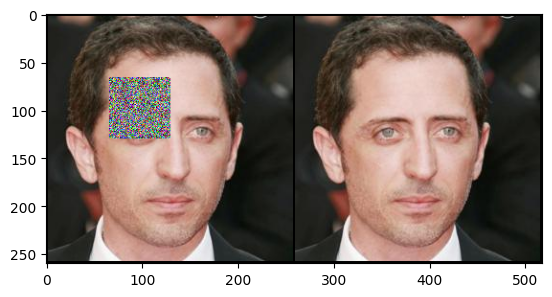

In [12]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

grid = make_grid([sample['cond_image'], sample['gt_image']])
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

In [13]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

In [14]:
len(train_loader)

1

# Training

In [15]:
! pip install -q torchcfm

In [16]:
from torchcfm.models.unet import UNetModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetModel(dim=(3, 256, 256), num_channels=32, num_res_blocks=1).to(device)
optimizer = torch.optim.Adam(model.parameters())

In [17]:
n_epochs = 1

from tqdm import tqdm
for epoch in range(n_epochs):
    losses = []
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()

        x1 = data['gt_image'].to(device)
        mask = data['mask'].to(device)

        x0 = torch.randn_like(x1).to(device)
        x_noise = (1.0-mask)*x1 + mask*x0

        t = torch.rand(x0.shape[0], 1, 1, 1).to(device)

        xt = t * x1 + (1 - t) * x_noise
        ut = x1 - x_noise

        t = t.squeeze()

        x_cond = xt*mask + (1.0-mask)*x1

        vt = model(t, x_cond)

        loss = torch.mean(((vt - ut) ** 2)*mask)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    print(f"epoch: {epoch}, loss: {avg_loss:.4}")

1it [00:01,  1.39s/it]

epoch: 0, loss: 0.0813


In [18]:
n_epochs = 1000

from tqdm import tqdm
for epoch in range(n_epochs):
    losses = []
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()

        x1 = data['gt_image'].to(device)
        mask = data['mask'].to(device)

        x0 = torch.randn_like(x1).to(device)
        x_noise = (1.0-mask)*x1 + mask*x0

        t = torch.rand(x0.shape[0], 1, 1, 1).to(device)

        xt = t * x1 + (1 - t) * x_noise
        ut = x1 - x_noise

        t = t.squeeze()

        x_cond = xt*mask + (1.0-mask)*x1

        vt = model(t, x_cond)

        loss = torch.mean(((vt - ut) ** 2)*mask)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    print(f"epoch: {epoch}, loss: {avg_loss:.4}")

1it [00:00,  1.72it/s]


epoch: 0, loss: 0.07167


1it [00:00,  1.99it/s]


epoch: 1, loss: 0.08347


1it [00:00,  1.98it/s]


epoch: 2, loss: 0.06788


1it [00:00,  1.97it/s]


epoch: 3, loss: 0.06567


1it [00:00,  2.01it/s]


epoch: 4, loss: 0.06177


1it [00:00,  1.96it/s]


epoch: 5, loss: 0.05713


1it [00:00,  1.99it/s]


epoch: 6, loss: 0.05483


1it [00:00,  1.98it/s]


epoch: 7, loss: 0.05215


1it [00:00,  2.01it/s]


epoch: 8, loss: 0.0496


1it [00:00,  1.99it/s]


epoch: 9, loss: 0.04799


1it [00:00,  1.99it/s]


epoch: 10, loss: 0.0424


1it [00:00,  1.99it/s]


epoch: 11, loss: 0.037


1it [00:00,  1.94it/s]


epoch: 12, loss: 0.03652


1it [00:00,  1.81it/s]


epoch: 13, loss: 0.03362


1it [00:00,  1.78it/s]


epoch: 14, loss: 0.03168


1it [00:00,  1.80it/s]


epoch: 15, loss: 0.02761


1it [00:00,  1.99it/s]


epoch: 16, loss: 0.02687


1it [00:00,  1.97it/s]


epoch: 17, loss: 0.02861


1it [00:00,  1.94it/s]


epoch: 18, loss: 0.02021


1it [00:00,  1.97it/s]


epoch: 19, loss: 0.01882


1it [00:00,  1.98it/s]


epoch: 20, loss: 0.01651


1it [00:00,  1.99it/s]


epoch: 21, loss: 0.0176


1it [00:00,  1.97it/s]


epoch: 22, loss: 0.01384


1it [00:00,  1.98it/s]


epoch: 23, loss: 0.01445


1it [00:00,  1.98it/s]


epoch: 24, loss: 0.01441


1it [00:00,  1.99it/s]


epoch: 25, loss: 0.01401


1it [00:00,  1.94it/s]


epoch: 26, loss: 0.01309


1it [00:00,  2.00it/s]


epoch: 27, loss: 0.01548


1it [00:00,  1.97it/s]


epoch: 28, loss: 0.01276


1it [00:00,  2.01it/s]


epoch: 29, loss: 0.01386


1it [00:00,  1.97it/s]


epoch: 30, loss: 0.01318


1it [00:00,  2.00it/s]


epoch: 31, loss: 0.009008


1it [00:00,  1.84it/s]


epoch: 32, loss: 0.01135


1it [00:00,  1.96it/s]


epoch: 33, loss: 0.01119


1it [00:00,  1.99it/s]


epoch: 34, loss: 0.01308


1it [00:00,  1.83it/s]


epoch: 35, loss: 0.01118


1it [00:00,  1.94it/s]


epoch: 36, loss: 0.01148


1it [00:00,  1.84it/s]


epoch: 37, loss: 0.01168


1it [00:00,  1.90it/s]


epoch: 38, loss: 0.01228


1it [00:00,  1.97it/s]


epoch: 39, loss: 0.009538


1it [00:00,  1.96it/s]


epoch: 40, loss: 0.00954


1it [00:00,  1.90it/s]


epoch: 41, loss: 0.008627


1it [00:00,  2.01it/s]


epoch: 42, loss: 0.009819


1it [00:00,  2.00it/s]


epoch: 43, loss: 0.009258


1it [00:00,  1.98it/s]


epoch: 44, loss: 0.008975


1it [00:00,  1.94it/s]


epoch: 45, loss: 0.009055


1it [00:00,  1.98it/s]


epoch: 46, loss: 0.009462


1it [00:00,  1.96it/s]


epoch: 47, loss: 0.0102


1it [00:00,  1.94it/s]


epoch: 48, loss: 0.009958


1it [00:00,  1.99it/s]


epoch: 49, loss: 0.007996


1it [00:00,  1.95it/s]


epoch: 50, loss: 0.005931


1it [00:00,  1.97it/s]


epoch: 51, loss: 0.007863


1it [00:00,  1.97it/s]


epoch: 52, loss: 0.006306


1it [00:00,  2.00it/s]


epoch: 53, loss: 0.006439


1it [00:00,  1.86it/s]


epoch: 54, loss: 0.004751


1it [00:00,  1.99it/s]


epoch: 55, loss: 0.00718


1it [00:00,  1.96it/s]


epoch: 56, loss: 0.008216


1it [00:00,  1.98it/s]


epoch: 57, loss: 0.004477


1it [00:00,  1.93it/s]


epoch: 58, loss: 0.00922


1it [00:00,  1.88it/s]


epoch: 59, loss: 0.008905


1it [00:00,  1.93it/s]


epoch: 60, loss: 0.007248


1it [00:00,  1.94it/s]


epoch: 61, loss: 0.006263


1it [00:00,  1.97it/s]


epoch: 62, loss: 0.009168


1it [00:00,  1.94it/s]


epoch: 63, loss: 0.006047


1it [00:00,  1.99it/s]


epoch: 64, loss: 0.00592


1it [00:00,  1.95it/s]


epoch: 65, loss: 0.009002


1it [00:00,  1.99it/s]


epoch: 66, loss: 0.008239


1it [00:00,  1.99it/s]


epoch: 67, loss: 0.005884


1it [00:00,  1.99it/s]


epoch: 68, loss: 0.006203


1it [00:00,  1.99it/s]


epoch: 69, loss: 0.005111


1it [00:00,  1.96it/s]


epoch: 70, loss: 0.005462


1it [00:00,  1.99it/s]


epoch: 71, loss: 0.004668


1it [00:00,  1.99it/s]


epoch: 72, loss: 0.006821


1it [00:00,  1.89it/s]


epoch: 73, loss: 0.004037


1it [00:00,  1.98it/s]


epoch: 74, loss: 0.006277


1it [00:00,  1.97it/s]


epoch: 75, loss: 0.00698


1it [00:00,  1.96it/s]


epoch: 76, loss: 0.004716


1it [00:00,  1.98it/s]


epoch: 77, loss: 0.004905


1it [00:00,  1.94it/s]


epoch: 78, loss: 0.00505


1it [00:00,  2.00it/s]


epoch: 79, loss: 0.005925


1it [00:00,  1.93it/s]


epoch: 80, loss: 0.006276


1it [00:00,  1.90it/s]


epoch: 81, loss: 0.007225


1it [00:00,  1.96it/s]


epoch: 82, loss: 0.006226


1it [00:00,  1.91it/s]


epoch: 83, loss: 0.003897


1it [00:00,  1.97it/s]


epoch: 84, loss: 0.004532


1it [00:00,  1.96it/s]


epoch: 85, loss: 0.005741


1it [00:00,  1.96it/s]


epoch: 86, loss: 0.005989


1it [00:00,  1.99it/s]


epoch: 87, loss: 0.005264


1it [00:00,  1.94it/s]


epoch: 88, loss: 0.006301


1it [00:00,  1.99it/s]


epoch: 89, loss: 0.005294


1it [00:00,  1.99it/s]


epoch: 90, loss: 0.003774


1it [00:00,  2.00it/s]


epoch: 91, loss: 0.005583


1it [00:00,  1.92it/s]


epoch: 92, loss: 0.005236


1it [00:00,  1.98it/s]


epoch: 93, loss: 0.004435


1it [00:00,  1.99it/s]


epoch: 94, loss: 0.007835


1it [00:00,  1.87it/s]


epoch: 95, loss: 0.003846


1it [00:00,  1.97it/s]


epoch: 96, loss: 0.005242


1it [00:00,  1.99it/s]


epoch: 97, loss: 0.005715


1it [00:00,  1.99it/s]


epoch: 98, loss: 0.003698


1it [00:00,  1.96it/s]


epoch: 99, loss: 0.005217


1it [00:00,  2.00it/s]


epoch: 100, loss: 0.00488


1it [00:00,  1.96it/s]


epoch: 101, loss: 0.007132


1it [00:00,  1.97it/s]


epoch: 102, loss: 0.006583


1it [00:00,  1.99it/s]


epoch: 103, loss: 0.005501


1it [00:00,  1.94it/s]


epoch: 104, loss: 0.00431


1it [00:00,  1.79it/s]


epoch: 105, loss: 0.005058


1it [00:00,  1.90it/s]


epoch: 106, loss: 0.006982


1it [00:00,  1.81it/s]


epoch: 107, loss: 0.004804


1it [00:00,  1.98it/s]


epoch: 108, loss: 0.006981


1it [00:00,  1.94it/s]


epoch: 109, loss: 0.005068


1it [00:00,  1.99it/s]


epoch: 110, loss: 0.003971


1it [00:00,  2.00it/s]


epoch: 111, loss: 0.005892


1it [00:00,  1.93it/s]


epoch: 112, loss: 0.005071


1it [00:00,  1.97it/s]


epoch: 113, loss: 0.004534


1it [00:00,  1.92it/s]


epoch: 114, loss: 0.00438


1it [00:00,  2.01it/s]


epoch: 115, loss: 0.004411


1it [00:00,  1.94it/s]


epoch: 116, loss: 0.00429


1it [00:00,  1.98it/s]


epoch: 117, loss: 0.003989


1it [00:00,  1.96it/s]


epoch: 118, loss: 0.00464


1it [00:00,  1.95it/s]


epoch: 119, loss: 0.004819


1it [00:00,  1.99it/s]


epoch: 120, loss: 0.005675


1it [00:00,  2.01it/s]


epoch: 121, loss: 0.004048


1it [00:00,  1.98it/s]


epoch: 122, loss: 0.005173


1it [00:00,  1.97it/s]


epoch: 123, loss: 0.006812


1it [00:00,  1.95it/s]


epoch: 124, loss: 0.005454


1it [00:00,  1.91it/s]


epoch: 125, loss: 0.005572


1it [00:00,  1.98it/s]


epoch: 126, loss: 0.005111


1it [00:00,  1.88it/s]


epoch: 127, loss: 0.004537


1it [00:00,  1.82it/s]


epoch: 128, loss: 0.00409


1it [00:00,  1.84it/s]


epoch: 129, loss: 0.00412


1it [00:00,  1.84it/s]


epoch: 130, loss: 0.004526


1it [00:00,  2.01it/s]


epoch: 131, loss: 0.005578


1it [00:00,  1.99it/s]


epoch: 132, loss: 0.00446


1it [00:00,  1.91it/s]


epoch: 133, loss: 0.008124


1it [00:00,  1.96it/s]


epoch: 134, loss: 0.004122


1it [00:00,  2.01it/s]


epoch: 135, loss: 0.004279


1it [00:00,  1.97it/s]


epoch: 136, loss: 0.004277


1it [00:00,  1.99it/s]


epoch: 137, loss: 0.004015


1it [00:00,  1.96it/s]


epoch: 138, loss: 0.004881


1it [00:00,  1.96it/s]


epoch: 139, loss: 0.003965


1it [00:00,  1.94it/s]


epoch: 140, loss: 0.005986


1it [00:00,  1.96it/s]


epoch: 141, loss: 0.003945


1it [00:00,  1.91it/s]


epoch: 142, loss: 0.004275


1it [00:00,  1.96it/s]


epoch: 143, loss: 0.003758


1it [00:00,  1.94it/s]


epoch: 144, loss: 0.005012


1it [00:00,  1.95it/s]


epoch: 145, loss: 0.004018


1it [00:00,  1.99it/s]


epoch: 146, loss: 0.00566


1it [00:00,  2.00it/s]


epoch: 147, loss: 0.004489


1it [00:00,  1.97it/s]


epoch: 148, loss: 0.004403


1it [00:00,  2.00it/s]


epoch: 149, loss: 0.00349


1it [00:00,  1.94it/s]


epoch: 150, loss: 0.003195


1it [00:00,  1.95it/s]


epoch: 151, loss: 0.003343


1it [00:00,  1.82it/s]


epoch: 152, loss: 0.00319


1it [00:00,  1.95it/s]


epoch: 153, loss: 0.00643


1it [00:00,  2.01it/s]


epoch: 154, loss: 0.004558


1it [00:00,  1.97it/s]


epoch: 155, loss: 0.005534


1it [00:00,  2.00it/s]


epoch: 156, loss: 0.006086


1it [00:00,  1.97it/s]


epoch: 157, loss: 0.003775


1it [00:00,  1.94it/s]


epoch: 158, loss: 0.004241


1it [00:00,  1.98it/s]


epoch: 159, loss: 0.003676


1it [00:00,  1.97it/s]


epoch: 160, loss: 0.004151


1it [00:00,  1.98it/s]


epoch: 161, loss: 0.003924


1it [00:00,  1.90it/s]


epoch: 162, loss: 0.003358


1it [00:00,  1.99it/s]


epoch: 163, loss: 0.004689


1it [00:00,  1.94it/s]


epoch: 164, loss: 0.003535


1it [00:00,  1.96it/s]


epoch: 165, loss: 0.003822


1it [00:00,  1.97it/s]


epoch: 166, loss: 0.004246


1it [00:00,  1.97it/s]


epoch: 167, loss: 0.004396


1it [00:00,  1.99it/s]


epoch: 168, loss: 0.003708


1it [00:00,  1.95it/s]


epoch: 169, loss: 0.003101


1it [00:00,  1.94it/s]


epoch: 170, loss: 0.004062


1it [00:00,  1.96it/s]


epoch: 171, loss: 0.00349


1it [00:00,  1.95it/s]


epoch: 172, loss: 0.004429


1it [00:00,  1.87it/s]


epoch: 173, loss: 0.005215


1it [00:00,  1.99it/s]


epoch: 174, loss: 0.006063


1it [00:00,  1.91it/s]


epoch: 175, loss: 0.004952


1it [00:00,  1.95it/s]


epoch: 176, loss: 0.003447


1it [00:00,  1.98it/s]


epoch: 177, loss: 0.004956


1it [00:00,  1.98it/s]


epoch: 178, loss: 0.004722


1it [00:00,  1.99it/s]


epoch: 179, loss: 0.006107


1it [00:00,  1.95it/s]


epoch: 180, loss: 0.005283


1it [00:00,  1.99it/s]


epoch: 181, loss: 0.004673


1it [00:00,  1.97it/s]


epoch: 182, loss: 0.004347


1it [00:00,  1.88it/s]


epoch: 183, loss: 0.004251


1it [00:00,  1.98it/s]


epoch: 184, loss: 0.00289


1it [00:00,  1.96it/s]


epoch: 185, loss: 0.004023


1it [00:00,  1.99it/s]


epoch: 186, loss: 0.004955


1it [00:00,  1.99it/s]


epoch: 187, loss: 0.003241


1it [00:00,  1.98it/s]


epoch: 188, loss: 0.004006


1it [00:00,  1.88it/s]


epoch: 189, loss: 0.004044


1it [00:00,  1.99it/s]


epoch: 190, loss: 0.003799


1it [00:00,  1.97it/s]


epoch: 191, loss: 0.004593


1it [00:00,  1.97it/s]


epoch: 192, loss: 0.003745


1it [00:00,  1.99it/s]


epoch: 193, loss: 0.002812


1it [00:00,  1.97it/s]


epoch: 194, loss: 0.004182


1it [00:00,  1.96it/s]


epoch: 195, loss: 0.005465


1it [00:00,  1.80it/s]


epoch: 196, loss: 0.003485


1it [00:00,  1.97it/s]


epoch: 197, loss: 0.004323


1it [00:00,  1.89it/s]


epoch: 198, loss: 0.005052


1it [00:00,  1.96it/s]


epoch: 199, loss: 0.003885


1it [00:00,  1.96it/s]


epoch: 200, loss: 0.005133


1it [00:00,  2.00it/s]


epoch: 201, loss: 0.004549


1it [00:00,  1.93it/s]


epoch: 202, loss: 0.003984


1it [00:00,  1.99it/s]


epoch: 203, loss: 0.00391


1it [00:00,  1.93it/s]


epoch: 204, loss: 0.003599


1it [00:00,  1.97it/s]


epoch: 205, loss: 0.005932


1it [00:00,  1.98it/s]


epoch: 206, loss: 0.004232


1it [00:00,  1.95it/s]


epoch: 207, loss: 0.003602


1it [00:00,  1.98it/s]


epoch: 208, loss: 0.00411


1it [00:00,  1.95it/s]


epoch: 209, loss: 0.002566


1it [00:00,  1.99it/s]


epoch: 210, loss: 0.003953


1it [00:00,  1.96it/s]


epoch: 211, loss: 0.003523


1it [00:00,  1.89it/s]


epoch: 212, loss: 0.002722


1it [00:00,  1.99it/s]


epoch: 213, loss: 0.005193


1it [00:00,  1.97it/s]


epoch: 214, loss: 0.003834


1it [00:00,  2.00it/s]


epoch: 215, loss: 0.003038


1it [00:00,  1.98it/s]


epoch: 216, loss: 0.003422


1it [00:00,  2.02it/s]


epoch: 217, loss: 0.005178


1it [00:00,  1.99it/s]


epoch: 218, loss: 0.003672


1it [00:00,  1.82it/s]


epoch: 219, loss: 0.005129


1it [00:00,  1.82it/s]


epoch: 220, loss: 0.003409


1it [00:00,  1.89it/s]


epoch: 221, loss: 0.003818


1it [00:00,  1.83it/s]


epoch: 222, loss: 0.003962


1it [00:00,  2.01it/s]


epoch: 223, loss: 0.00287


1it [00:00,  1.95it/s]


epoch: 224, loss: 0.00312


1it [00:00,  2.00it/s]


epoch: 225, loss: 0.003653


1it [00:00,  1.98it/s]


epoch: 226, loss: 0.0032


1it [00:00,  1.94it/s]


epoch: 227, loss: 0.003468


1it [00:00,  1.96it/s]


epoch: 228, loss: 0.00326


1it [00:00,  1.95it/s]


epoch: 229, loss: 0.004059


1it [00:00,  1.99it/s]


epoch: 230, loss: 0.003964


1it [00:00,  1.99it/s]


epoch: 231, loss: 0.004335


1it [00:00,  1.99it/s]


epoch: 232, loss: 0.003525


1it [00:00,  1.96it/s]


epoch: 233, loss: 0.002806


1it [00:00,  1.99it/s]


epoch: 234, loss: 0.004302


1it [00:00,  1.99it/s]


epoch: 235, loss: 0.002614


1it [00:00,  1.99it/s]


epoch: 236, loss: 0.002919


1it [00:00,  1.93it/s]


epoch: 237, loss: 0.006205


1it [00:00,  2.00it/s]


epoch: 238, loss: 0.004449


1it [00:00,  1.98it/s]


epoch: 239, loss: 0.004416


1it [00:00,  1.98it/s]


epoch: 240, loss: 0.00428


1it [00:00,  1.99it/s]


epoch: 241, loss: 0.004763


1it [00:00,  1.82it/s]


epoch: 242, loss: 0.003073


1it [00:00,  1.96it/s]


epoch: 243, loss: 0.003151


1it [00:00,  1.81it/s]


epoch: 244, loss: 0.003541


1it [00:00,  1.96it/s]


epoch: 245, loss: 0.003755


1it [00:00,  1.90it/s]


epoch: 246, loss: 0.00306


1it [00:00,  2.00it/s]


epoch: 247, loss: 0.003765


1it [00:00,  1.98it/s]


epoch: 248, loss: 0.004173


1it [00:00,  1.95it/s]


epoch: 249, loss: 0.003261


1it [00:00,  1.96it/s]


epoch: 250, loss: 0.002956


1it [00:00,  1.97it/s]


epoch: 251, loss: 0.003301


1it [00:00,  1.97it/s]


epoch: 252, loss: 0.003626


1it [00:00,  2.01it/s]


epoch: 253, loss: 0.003795


1it [00:00,  1.95it/s]


epoch: 254, loss: 0.003033


1it [00:00,  1.94it/s]


epoch: 255, loss: 0.004769


1it [00:00,  1.96it/s]


epoch: 256, loss: 0.004608


1it [00:00,  2.01it/s]


epoch: 257, loss: 0.002291


1it [00:00,  1.94it/s]


epoch: 258, loss: 0.003998


1it [00:00,  1.94it/s]


epoch: 259, loss: 0.003046


1it [00:00,  1.97it/s]


epoch: 260, loss: 0.004087


1it [00:00,  2.01it/s]


epoch: 261, loss: 0.003587


1it [00:00,  1.95it/s]


epoch: 262, loss: 0.002929


1it [00:00,  2.01it/s]


epoch: 263, loss: 0.002927


1it [00:00,  1.96it/s]


epoch: 264, loss: 0.005218


1it [00:00,  1.88it/s]


epoch: 265, loss: 0.00427


1it [00:00,  1.98it/s]


epoch: 266, loss: 0.004058


1it [00:00,  1.85it/s]


epoch: 267, loss: 0.005696


1it [00:00,  1.97it/s]


epoch: 268, loss: 0.00272


1it [00:00,  2.00it/s]


epoch: 269, loss: 0.002977


1it [00:00,  1.95it/s]


epoch: 270, loss: 0.004352


1it [00:00,  1.98it/s]


epoch: 271, loss: 0.005333


1it [00:00,  1.97it/s]


epoch: 272, loss: 0.00437


1it [00:00,  1.99it/s]


epoch: 273, loss: 0.005903


1it [00:00,  1.95it/s]


epoch: 274, loss: 0.002715


1it [00:00,  1.99it/s]


epoch: 275, loss: 0.004599


1it [00:00,  2.00it/s]


epoch: 276, loss: 0.003567


1it [00:00,  2.00it/s]


epoch: 277, loss: 0.003149


1it [00:00,  1.98it/s]


epoch: 278, loss: 0.00368


1it [00:00,  1.99it/s]


epoch: 279, loss: 0.0044


1it [00:00,  1.96it/s]


epoch: 280, loss: 0.004831


1it [00:00,  1.99it/s]


epoch: 281, loss: 0.002853


1it [00:00,  1.93it/s]


epoch: 282, loss: 0.003954


1it [00:00,  1.98it/s]


epoch: 283, loss: 0.004198


1it [00:00,  1.98it/s]


epoch: 284, loss: 0.004921


1it [00:00,  2.00it/s]


epoch: 285, loss: 0.003888


1it [00:00,  1.98it/s]


epoch: 286, loss: 0.003201


1it [00:00,  1.96it/s]


epoch: 287, loss: 0.00285


1it [00:00,  1.93it/s]


epoch: 288, loss: 0.003751


1it [00:00,  1.95it/s]


epoch: 289, loss: 0.003287


1it [00:00,  1.93it/s]


epoch: 290, loss: 0.002784


1it [00:00,  1.82it/s]


epoch: 291, loss: 0.00372


1it [00:00,  1.96it/s]


epoch: 292, loss: 0.003905


1it [00:00,  2.00it/s]


epoch: 293, loss: 0.004785


1it [00:00,  2.01it/s]


epoch: 294, loss: 0.004568


1it [00:00,  1.96it/s]


epoch: 295, loss: 0.004264


1it [00:00,  1.99it/s]


epoch: 296, loss: 0.003268


1it [00:00,  1.96it/s]


epoch: 297, loss: 0.004196


1it [00:00,  2.00it/s]


epoch: 298, loss: 0.003366


1it [00:00,  1.95it/s]


epoch: 299, loss: 0.003312


1it [00:00,  2.00it/s]


epoch: 300, loss: 0.002654


1it [00:00,  2.00it/s]


epoch: 301, loss: 0.002347


1it [00:00,  1.91it/s]


epoch: 302, loss: 0.00331


1it [00:00,  2.00it/s]


epoch: 303, loss: 0.003673


1it [00:00,  1.98it/s]


epoch: 304, loss: 0.002433


1it [00:00,  1.94it/s]


epoch: 305, loss: 0.002772


1it [00:00,  1.98it/s]


epoch: 306, loss: 0.002358


1it [00:00,  1.95it/s]


epoch: 307, loss: 0.005174


1it [00:00,  1.97it/s]


epoch: 308, loss: 0.004115


1it [00:00,  2.00it/s]


epoch: 309, loss: 0.003069


1it [00:00,  1.97it/s]


epoch: 310, loss: 0.003283


1it [00:00,  1.92it/s]


epoch: 311, loss: 0.0045


1it [00:00,  1.88it/s]


epoch: 312, loss: 0.004185


1it [00:00,  1.84it/s]


epoch: 313, loss: 0.002916


1it [00:00,  1.95it/s]


epoch: 314, loss: 0.002372


1it [00:00,  1.85it/s]


epoch: 315, loss: 0.002633


1it [00:00,  1.99it/s]


epoch: 316, loss: 0.003457


1it [00:00,  1.98it/s]


epoch: 317, loss: 0.003244


1it [00:00,  1.96it/s]


epoch: 318, loss: 0.003815


1it [00:00,  1.97it/s]


epoch: 319, loss: 0.002834


1it [00:00,  1.99it/s]


epoch: 320, loss: 0.002594


1it [00:00,  1.97it/s]


epoch: 321, loss: 0.003489


1it [00:00,  2.01it/s]


epoch: 322, loss: 0.003137


1it [00:00,  2.01it/s]


epoch: 323, loss: 0.003075


1it [00:00,  1.99it/s]


epoch: 324, loss: 0.002557


1it [00:00,  1.99it/s]


epoch: 325, loss: 0.005352


1it [00:00,  1.99it/s]


epoch: 326, loss: 0.002654


1it [00:00,  1.96it/s]


epoch: 327, loss: 0.003093


1it [00:00,  1.95it/s]


epoch: 328, loss: 0.004617


1it [00:00,  1.96it/s]


epoch: 329, loss: 0.002526


1it [00:00,  1.97it/s]


epoch: 330, loss: 0.002072


1it [00:00,  1.97it/s]


epoch: 331, loss: 0.003665


1it [00:00,  1.98it/s]


epoch: 332, loss: 0.004982


1it [00:00,  1.98it/s]


epoch: 333, loss: 0.004063


1it [00:00,  1.82it/s]


epoch: 334, loss: 0.004257


1it [00:00,  1.79it/s]


epoch: 335, loss: 0.003995


1it [00:00,  1.90it/s]


epoch: 336, loss: 0.004199


1it [00:00,  1.95it/s]


epoch: 337, loss: 0.003008


1it [00:00,  2.00it/s]


epoch: 338, loss: 0.004518


1it [00:00,  1.98it/s]


epoch: 339, loss: 0.002901


1it [00:00,  1.97it/s]


epoch: 340, loss: 0.003707


1it [00:00,  1.99it/s]


epoch: 341, loss: 0.00335


1it [00:00,  1.99it/s]


epoch: 342, loss: 0.002942


1it [00:00,  1.93it/s]


epoch: 343, loss: 0.002321


1it [00:00,  1.96it/s]


epoch: 344, loss: 0.005071


1it [00:00,  1.89it/s]


epoch: 345, loss: 0.003411


1it [00:00,  1.98it/s]


epoch: 346, loss: 0.003151


1it [00:00,  1.98it/s]


epoch: 347, loss: 0.00292


1it [00:00,  1.95it/s]


epoch: 348, loss: 0.002391


1it [00:00,  1.97it/s]


epoch: 349, loss: 0.002661


1it [00:00,  1.96it/s]


epoch: 350, loss: 0.002472


1it [00:00,  2.01it/s]


epoch: 351, loss: 0.003283


1it [00:00,  1.93it/s]


epoch: 352, loss: 0.003258


1it [00:00,  2.01it/s]


epoch: 353, loss: 0.003978


1it [00:00,  1.96it/s]


epoch: 354, loss: 0.002565


1it [00:00,  1.99it/s]


epoch: 355, loss: 0.002562


1it [00:00,  1.93it/s]


epoch: 356, loss: 0.002359


1it [00:00,  1.80it/s]


epoch: 357, loss: 0.002715


1it [00:00,  1.95it/s]


epoch: 358, loss: 0.003035


1it [00:00,  1.91it/s]


epoch: 359, loss: 0.002312


1it [00:00,  1.95it/s]


epoch: 360, loss: 0.002996


1it [00:00,  1.94it/s]


epoch: 361, loss: 0.00298


1it [00:00,  1.98it/s]


epoch: 362, loss: 0.003355


1it [00:00,  1.99it/s]


epoch: 363, loss: 0.004671


1it [00:00,  1.96it/s]


epoch: 364, loss: 0.005701


1it [00:00,  2.00it/s]


epoch: 365, loss: 0.003888


1it [00:00,  2.01it/s]


epoch: 366, loss: 0.004448


1it [00:00,  1.98it/s]


epoch: 367, loss: 0.004504


1it [00:00,  2.00it/s]


epoch: 368, loss: 0.003335


1it [00:00,  1.95it/s]


epoch: 369, loss: 0.003815


1it [00:00,  1.99it/s]


epoch: 370, loss: 0.003473


1it [00:00,  1.97it/s]


epoch: 371, loss: 0.003738


1it [00:00,  2.01it/s]


epoch: 372, loss: 0.002904


1it [00:00,  1.94it/s]


epoch: 373, loss: 0.004402


1it [00:00,  1.99it/s]


epoch: 374, loss: 0.00433


1it [00:00,  1.98it/s]


epoch: 375, loss: 0.003291


1it [00:00,  1.93it/s]


epoch: 376, loss: 0.003492


1it [00:00,  1.95it/s]


epoch: 377, loss: 0.003189


1it [00:00,  1.98it/s]


epoch: 378, loss: 0.003196


1it [00:00,  1.92it/s]


epoch: 379, loss: 0.00345


1it [00:00,  1.94it/s]


epoch: 380, loss: 0.0029


1it [00:00,  1.92it/s]


epoch: 381, loss: 0.003285


1it [00:00,  1.93it/s]


epoch: 382, loss: 0.002885


1it [00:00,  1.73it/s]


epoch: 383, loss: 0.002801


1it [00:00,  2.00it/s]


epoch: 384, loss: 0.002891


1it [00:00,  1.97it/s]


epoch: 385, loss: 0.002223


1it [00:00,  1.98it/s]


epoch: 386, loss: 0.002428


1it [00:00,  1.95it/s]


epoch: 387, loss: 0.002829


1it [00:00,  1.98it/s]


epoch: 388, loss: 0.002587


1it [00:00,  1.95it/s]


epoch: 389, loss: 0.002586


1it [00:00,  1.90it/s]


epoch: 390, loss: 0.002595


1it [00:00,  1.88it/s]


epoch: 391, loss: 0.002209


1it [00:00,  2.00it/s]


epoch: 392, loss: 0.003917


1it [00:00,  2.00it/s]


epoch: 393, loss: 0.003175


1it [00:00,  2.00it/s]


epoch: 394, loss: 0.002886


1it [00:00,  1.98it/s]


epoch: 395, loss: 0.004367


1it [00:00,  1.93it/s]


epoch: 396, loss: 0.002233


1it [00:00,  1.99it/s]


epoch: 397, loss: 0.002973


1it [00:00,  1.97it/s]


epoch: 398, loss: 0.002468


1it [00:00,  1.97it/s]


epoch: 399, loss: 0.004335


1it [00:00,  2.01it/s]


epoch: 400, loss: 0.002593


1it [00:00,  1.95it/s]


epoch: 401, loss: 0.003117


1it [00:00,  2.00it/s]


epoch: 402, loss: 0.00353


1it [00:00,  1.89it/s]


epoch: 403, loss: 0.002093


1it [00:00,  1.92it/s]


epoch: 404, loss: 0.00301


1it [00:00,  1.93it/s]


epoch: 405, loss: 0.003382


1it [00:00,  1.93it/s]


epoch: 406, loss: 0.003624


1it [00:00,  1.99it/s]


epoch: 407, loss: 0.003936


1it [00:00,  1.99it/s]


epoch: 408, loss: 0.002452


1it [00:00,  2.00it/s]


epoch: 409, loss: 0.00316


1it [00:00,  1.96it/s]


epoch: 410, loss: 0.003296


1it [00:00,  1.97it/s]


epoch: 411, loss: 0.002229


1it [00:00,  2.00it/s]


epoch: 412, loss: 0.002434


1it [00:00,  1.96it/s]


epoch: 413, loss: 0.004521


1it [00:00,  1.99it/s]


epoch: 414, loss: 0.002987


1it [00:00,  1.98it/s]


epoch: 415, loss: 0.002581


1it [00:00,  1.92it/s]


epoch: 416, loss: 0.004431


1it [00:00,  1.97it/s]


epoch: 417, loss: 0.002913


1it [00:00,  1.97it/s]


epoch: 418, loss: 0.003138


1it [00:00,  1.95it/s]


epoch: 419, loss: 0.004908


1it [00:00,  1.96it/s]


epoch: 420, loss: 0.002456


1it [00:00,  1.97it/s]


epoch: 421, loss: 0.003322


1it [00:00,  2.00it/s]


epoch: 422, loss: 0.003234


1it [00:00,  1.97it/s]


epoch: 423, loss: 0.002695


1it [00:00,  2.01it/s]


epoch: 424, loss: 0.004932


1it [00:00,  1.94it/s]


epoch: 425, loss: 0.003919


1it [00:00,  1.90it/s]


epoch: 426, loss: 0.002903


1it [00:00,  1.84it/s]


epoch: 427, loss: 0.003077


1it [00:00,  1.90it/s]


epoch: 428, loss: 0.003145


1it [00:00,  1.89it/s]


epoch: 429, loss: 0.003133


1it [00:00,  1.94it/s]


epoch: 430, loss: 0.002601


1it [00:00,  1.93it/s]


epoch: 431, loss: 0.005971


1it [00:00,  1.89it/s]


epoch: 432, loss: 0.003502


1it [00:00,  1.96it/s]


epoch: 433, loss: 0.002303


1it [00:00,  1.97it/s]


epoch: 434, loss: 0.003501


1it [00:00,  1.98it/s]


epoch: 435, loss: 0.00298


1it [00:00,  2.01it/s]


epoch: 436, loss: 0.002858


1it [00:00,  1.97it/s]


epoch: 437, loss: 0.002608


1it [00:00,  1.99it/s]


epoch: 438, loss: 0.003494


1it [00:00,  1.91it/s]


epoch: 439, loss: 0.002494


1it [00:00,  1.99it/s]


epoch: 440, loss: 0.002698


1it [00:00,  1.97it/s]


epoch: 441, loss: 0.003151


1it [00:00,  1.96it/s]


epoch: 442, loss: 0.002176


1it [00:00,  1.94it/s]


epoch: 443, loss: 0.00299


1it [00:00,  1.99it/s]


epoch: 444, loss: 0.002824


1it [00:00,  1.99it/s]


epoch: 445, loss: 0.003371


1it [00:00,  1.94it/s]


epoch: 446, loss: 0.004192


1it [00:00,  1.98it/s]


epoch: 447, loss: 0.002488


1it [00:00,  1.92it/s]


epoch: 448, loss: 0.002723


1it [00:00,  1.91it/s]


epoch: 449, loss: 0.003369


1it [00:00,  1.94it/s]


epoch: 450, loss: 0.00209


1it [00:00,  1.94it/s]


epoch: 451, loss: 0.001862


1it [00:00,  1.80it/s]


epoch: 452, loss: 0.002614


1it [00:00,  1.90it/s]


epoch: 453, loss: 0.003237


1it [00:00,  1.94it/s]


epoch: 454, loss: 0.002415


1it [00:00,  1.98it/s]


epoch: 455, loss: 0.002837


1it [00:00,  1.98it/s]


epoch: 456, loss: 0.003327


1it [00:00,  1.96it/s]


epoch: 457, loss: 0.002701


1it [00:00,  1.99it/s]


epoch: 458, loss: 0.003345


1it [00:00,  2.00it/s]


epoch: 459, loss: 0.002361


1it [00:00,  1.96it/s]


epoch: 460, loss: 0.002963


1it [00:00,  1.96it/s]


epoch: 461, loss: 0.002823


1it [00:00,  1.97it/s]


epoch: 462, loss: 0.002867


1it [00:00,  1.98it/s]


epoch: 463, loss: 0.00444


1it [00:00,  1.99it/s]


epoch: 464, loss: 0.002661


1it [00:00,  1.96it/s]


epoch: 465, loss: 0.0036


1it [00:00,  1.96it/s]


epoch: 466, loss: 0.002742


1it [00:00,  1.97it/s]


epoch: 467, loss: 0.002044


1it [00:00,  1.94it/s]


epoch: 468, loss: 0.002286


1it [00:00,  1.97it/s]


epoch: 469, loss: 0.003585


1it [00:00,  1.96it/s]


epoch: 470, loss: 0.0024


1it [00:00,  1.93it/s]


epoch: 471, loss: 0.001899


1it [00:00,  1.90it/s]


epoch: 472, loss: 0.002901


1it [00:00,  1.87it/s]


epoch: 473, loss: 0.002099


1it [00:00,  1.89it/s]


epoch: 474, loss: 0.002843


1it [00:00,  1.80it/s]


epoch: 475, loss: 0.00256


1it [00:00,  1.97it/s]


epoch: 476, loss: 0.003471


1it [00:00,  1.91it/s]


epoch: 477, loss: 0.002088


1it [00:00,  1.96it/s]


epoch: 478, loss: 0.002256


1it [00:00,  1.89it/s]


epoch: 479, loss: 0.003035


1it [00:00,  1.95it/s]


epoch: 480, loss: 0.001665


1it [00:00,  1.95it/s]


epoch: 481, loss: 0.002987


1it [00:00,  2.00it/s]


epoch: 482, loss: 0.001628


1it [00:00,  1.97it/s]


epoch: 483, loss: 0.003072


1it [00:00,  2.00it/s]


epoch: 484, loss: 0.002895


1it [00:00,  1.86it/s]


epoch: 485, loss: 0.002452


1it [00:00,  1.96it/s]


epoch: 486, loss: 0.003485


1it [00:00,  2.00it/s]


epoch: 487, loss: 0.003383


1it [00:00,  1.99it/s]


epoch: 488, loss: 0.002277


1it [00:00,  1.94it/s]


epoch: 489, loss: 0.003058


1it [00:00,  1.88it/s]


epoch: 490, loss: 0.003138


1it [00:00,  1.92it/s]


epoch: 491, loss: 0.00475


1it [00:00,  1.99it/s]


epoch: 492, loss: 0.003003


1it [00:00,  1.94it/s]


epoch: 493, loss: 0.002386


1it [00:00,  1.99it/s]


epoch: 494, loss: 0.002426


1it [00:00,  1.63it/s]


epoch: 495, loss: 0.002221


1it [00:00,  1.81it/s]


epoch: 496, loss: 0.004034


1it [00:00,  1.77it/s]


epoch: 497, loss: 0.002399


1it [00:00,  1.87it/s]


epoch: 498, loss: 0.002631


1it [00:00,  1.93it/s]


epoch: 499, loss: 0.002867


1it [00:00,  1.96it/s]


epoch: 500, loss: 0.002879


1it [00:00,  2.01it/s]


epoch: 501, loss: 0.002943


1it [00:00,  1.86it/s]


epoch: 502, loss: 0.001803


1it [00:00,  1.97it/s]


epoch: 503, loss: 0.002493


1it [00:00,  1.98it/s]


epoch: 504, loss: 0.001796


1it [00:00,  1.95it/s]


epoch: 505, loss: 0.004236


1it [00:00,  1.99it/s]


epoch: 506, loss: 0.001779


1it [00:00,  2.01it/s]


epoch: 507, loss: 0.002719


1it [00:00,  1.98it/s]


epoch: 508, loss: 0.004102


1it [00:00,  1.95it/s]


epoch: 509, loss: 0.001955


1it [00:00,  1.99it/s]


epoch: 510, loss: 0.003166


1it [00:00,  1.97it/s]


epoch: 511, loss: 0.002985


1it [00:00,  1.97it/s]


epoch: 512, loss: 0.003978


1it [00:00,  2.01it/s]


epoch: 513, loss: 0.00283


1it [00:00,  1.99it/s]


epoch: 514, loss: 0.002475


1it [00:00,  1.96it/s]


epoch: 515, loss: 0.003539


1it [00:00,  1.94it/s]


epoch: 516, loss: 0.002651


1it [00:00,  1.95it/s]


epoch: 517, loss: 0.003751


1it [00:00,  1.96it/s]


epoch: 518, loss: 0.002438


1it [00:00,  1.95it/s]


epoch: 519, loss: 0.003634


1it [00:00,  1.80it/s]


epoch: 520, loss: 0.0028


1it [00:00,  1.98it/s]


epoch: 521, loss: 0.002531


1it [00:00,  1.96it/s]


epoch: 522, loss: 0.002802


1it [00:00,  1.99it/s]


epoch: 523, loss: 0.002758


1it [00:00,  1.97it/s]


epoch: 524, loss: 0.001891


1it [00:00,  2.01it/s]


epoch: 525, loss: 0.002588


1it [00:00,  1.92it/s]


epoch: 526, loss: 0.001571


1it [00:00,  1.94it/s]


epoch: 527, loss: 0.002238


1it [00:00,  1.93it/s]


epoch: 528, loss: 0.003463


1it [00:00,  1.99it/s]


epoch: 529, loss: 0.00207


1it [00:00,  1.94it/s]


epoch: 530, loss: 0.003252


1it [00:00,  1.87it/s]


epoch: 531, loss: 0.003318


1it [00:00,  1.96it/s]


epoch: 532, loss: 0.002484


1it [00:00,  1.93it/s]


epoch: 533, loss: 0.003219


1it [00:00,  1.99it/s]


epoch: 534, loss: 0.002838


1it [00:00,  1.96it/s]


epoch: 535, loss: 0.002989


1it [00:00,  1.99it/s]


epoch: 536, loss: 0.004053


1it [00:00,  1.99it/s]


epoch: 537, loss: 0.003969


1it [00:00,  1.93it/s]


epoch: 538, loss: 0.00224


1it [00:00,  1.99it/s]


epoch: 539, loss: 0.003433


1it [00:00,  1.94it/s]


epoch: 540, loss: 0.002681


1it [00:00,  1.90it/s]


epoch: 541, loss: 0.00493


1it [00:00,  1.92it/s]


epoch: 542, loss: 0.004036


1it [00:00,  1.87it/s]


epoch: 543, loss: 0.003821


1it [00:00,  1.91it/s]


epoch: 544, loss: 0.001885


1it [00:00,  1.95it/s]


epoch: 545, loss: 0.002335


1it [00:00,  1.98it/s]


epoch: 546, loss: 0.005148


1it [00:00,  1.94it/s]


epoch: 547, loss: 0.001817


1it [00:00,  1.98it/s]


epoch: 548, loss: 0.003788


1it [00:00,  2.00it/s]


epoch: 549, loss: 0.002299


1it [00:00,  1.91it/s]


epoch: 550, loss: 0.003474


1it [00:00,  1.98it/s]


epoch: 551, loss: 0.003327


1it [00:00,  2.00it/s]


epoch: 552, loss: 0.002609


1it [00:00,  1.93it/s]


epoch: 553, loss: 0.002895


1it [00:00,  1.98it/s]


epoch: 554, loss: 0.004107


1it [00:00,  1.95it/s]


epoch: 555, loss: 0.00248


1it [00:00,  1.95it/s]


epoch: 556, loss: 0.002428


1it [00:00,  1.96it/s]


epoch: 557, loss: 0.002502


1it [00:00,  1.94it/s]


epoch: 558, loss: 0.002428


1it [00:00,  1.99it/s]


epoch: 559, loss: 0.002509


1it [00:00,  1.96it/s]


epoch: 560, loss: 0.002493


1it [00:00,  1.98it/s]


epoch: 561, loss: 0.002252


1it [00:00,  1.99it/s]


epoch: 562, loss: 0.004163


1it [00:00,  1.96it/s]


epoch: 563, loss: 0.00248


1it [00:00,  1.91it/s]


epoch: 564, loss: 0.002571


1it [00:00,  1.94it/s]


epoch: 565, loss: 0.00312


1it [00:00,  1.78it/s]


epoch: 566, loss: 0.003651


1it [00:00,  1.98it/s]


epoch: 567, loss: 0.002655


1it [00:00,  1.97it/s]


epoch: 568, loss: 0.002028


1it [00:00,  1.83it/s]


epoch: 569, loss: 0.002508


1it [00:00,  1.84it/s]


epoch: 570, loss: 0.002821


1it [00:00,  1.96it/s]


epoch: 571, loss: 0.004051


1it [00:00,  1.94it/s]


epoch: 572, loss: 0.002347


1it [00:00,  1.96it/s]


epoch: 573, loss: 0.00254


1it [00:00,  1.87it/s]


epoch: 574, loss: 0.003257


1it [00:00,  2.01it/s]


epoch: 575, loss: 0.001904


1it [00:00,  1.97it/s]


epoch: 576, loss: 0.001866


1it [00:00,  1.93it/s]


epoch: 577, loss: 0.00316


1it [00:00,  1.98it/s]


epoch: 578, loss: 0.00185


1it [00:00,  1.99it/s]


epoch: 579, loss: 0.003364


1it [00:00,  1.91it/s]


epoch: 580, loss: 0.002816


1it [00:00,  1.99it/s]


epoch: 581, loss: 0.002017


1it [00:00,  1.95it/s]


epoch: 582, loss: 0.001913


1it [00:00,  1.99it/s]


epoch: 583, loss: 0.002109


1it [00:00,  1.99it/s]


epoch: 584, loss: 0.002416


1it [00:00,  1.97it/s]


epoch: 585, loss: 0.001726


1it [00:00,  2.00it/s]


epoch: 586, loss: 0.002462


1it [00:00,  1.92it/s]


epoch: 587, loss: 0.002055


1it [00:00,  1.93it/s]


epoch: 588, loss: 0.002232


1it [00:00,  1.93it/s]


epoch: 589, loss: 0.002157


1it [00:00,  1.97it/s]


epoch: 590, loss: 0.002075


1it [00:00,  2.00it/s]


epoch: 591, loss: 0.005166


1it [00:00,  1.98it/s]


epoch: 592, loss: 0.00175


1it [00:00,  1.96it/s]


epoch: 593, loss: 0.002661


1it [00:00,  1.95it/s]


epoch: 594, loss: 0.003919


1it [00:00,  1.95it/s]


epoch: 595, loss: 0.003692


1it [00:00,  1.98it/s]


epoch: 596, loss: 0.003574


1it [00:00,  1.93it/s]


epoch: 597, loss: 0.0032


1it [00:00,  2.00it/s]


epoch: 598, loss: 0.002975


1it [00:00,  1.97it/s]


epoch: 599, loss: 0.001901


1it [00:00,  1.98it/s]


epoch: 600, loss: 0.003474


1it [00:00,  1.99it/s]


epoch: 601, loss: 0.002271


1it [00:00,  1.98it/s]


epoch: 602, loss: 0.004102


1it [00:00,  1.96it/s]


epoch: 603, loss: 0.001915


1it [00:00,  1.95it/s]


epoch: 604, loss: 0.00204


1it [00:00,  1.95it/s]


epoch: 605, loss: 0.002859


1it [00:00,  1.99it/s]


epoch: 606, loss: 0.002805


1it [00:00,  2.00it/s]


epoch: 607, loss: 0.003791


1it [00:00,  2.00it/s]


epoch: 608, loss: 0.004265


1it [00:00,  1.89it/s]


epoch: 609, loss: 0.002906


1it [00:00,  1.96it/s]


epoch: 610, loss: 0.001746


1it [00:00,  1.95it/s]


epoch: 611, loss: 0.003465


1it [00:00,  1.78it/s]


epoch: 612, loss: 0.002387


1it [00:00,  1.97it/s]


epoch: 613, loss: 0.003934


1it [00:00,  1.90it/s]


epoch: 614, loss: 0.002258


1it [00:00,  2.00it/s]


epoch: 615, loss: 0.002264


1it [00:00,  1.95it/s]


epoch: 616, loss: 0.003193


1it [00:00,  2.00it/s]


epoch: 617, loss: 0.001613


1it [00:00,  1.95it/s]


epoch: 618, loss: 0.002386


1it [00:00,  2.03it/s]


epoch: 619, loss: 0.002018


1it [00:00,  1.93it/s]


epoch: 620, loss: 0.00189


1it [00:00,  2.00it/s]


epoch: 621, loss: 0.001688


1it [00:00,  1.99it/s]


epoch: 622, loss: 0.002238


1it [00:00,  1.96it/s]


epoch: 623, loss: 0.002245


1it [00:00,  1.98it/s]


epoch: 624, loss: 0.001937


1it [00:00,  2.00it/s]


epoch: 625, loss: 0.001542


1it [00:00,  2.00it/s]


epoch: 626, loss: 0.002427


1it [00:00,  2.00it/s]


epoch: 627, loss: 0.001891


1it [00:00,  1.95it/s]


epoch: 628, loss: 0.002405


1it [00:00,  2.02it/s]


epoch: 629, loss: 0.001298


1it [00:00,  1.99it/s]


epoch: 630, loss: 0.002186


1it [00:00,  2.00it/s]


epoch: 631, loss: 0.002086


1it [00:00,  1.93it/s]


epoch: 632, loss: 0.002833


1it [00:00,  1.93it/s]


epoch: 633, loss: 0.002904


1it [00:00,  1.93it/s]


epoch: 634, loss: 0.003032


1it [00:00,  1.87it/s]


epoch: 635, loss: 0.002188


1it [00:00,  1.89it/s]


epoch: 636, loss: 0.002204


1it [00:00,  1.96it/s]


epoch: 637, loss: 0.001815


1it [00:00,  1.98it/s]


epoch: 638, loss: 0.001886


1it [00:00,  1.96it/s]


epoch: 639, loss: 0.003293


1it [00:00,  1.95it/s]


epoch: 640, loss: 0.002644


1it [00:00,  1.91it/s]


epoch: 641, loss: 0.003224


1it [00:00,  2.01it/s]


epoch: 642, loss: 0.003094


1it [00:00,  1.98it/s]


epoch: 643, loss: 0.002041


1it [00:00,  2.01it/s]


epoch: 644, loss: 0.003454


1it [00:00,  1.95it/s]


epoch: 645, loss: 0.002257


1it [00:00,  1.97it/s]


epoch: 646, loss: 0.00171


1it [00:00,  1.96it/s]


epoch: 647, loss: 0.003676


1it [00:00,  1.96it/s]


epoch: 648, loss: 0.001217


1it [00:00,  1.92it/s]


epoch: 649, loss: 0.002128


1it [00:00,  1.98it/s]


epoch: 650, loss: 0.002938


1it [00:00,  1.99it/s]


epoch: 651, loss: 0.001665


1it [00:00,  1.92it/s]


epoch: 652, loss: 0.003388


1it [00:00,  1.98it/s]


epoch: 653, loss: 0.002019


1it [00:00,  1.99it/s]


epoch: 654, loss: 0.002664


1it [00:00,  1.93it/s]


epoch: 655, loss: 0.003248


1it [00:00,  1.82it/s]


epoch: 656, loss: 0.002687


1it [00:00,  1.82it/s]


epoch: 657, loss: 0.002452


1it [00:00,  1.81it/s]


epoch: 658, loss: 0.001957


1it [00:00,  1.93it/s]


epoch: 659, loss: 0.002519


1it [00:00,  1.81it/s]


epoch: 660, loss: 0.002541


1it [00:00,  1.95it/s]


epoch: 661, loss: 0.002659


1it [00:00,  1.96it/s]


epoch: 662, loss: 0.002404


1it [00:00,  1.94it/s]


epoch: 663, loss: 0.00263


1it [00:00,  1.97it/s]


epoch: 664, loss: 0.002441


1it [00:00,  1.94it/s]


epoch: 665, loss: 0.002554


1it [00:00,  1.99it/s]


epoch: 666, loss: 0.004416


1it [00:00,  1.98it/s]


epoch: 667, loss: 0.00169


1it [00:00,  1.97it/s]


epoch: 668, loss: 0.003225


1it [00:00,  1.95it/s]


epoch: 669, loss: 0.002376


1it [00:00,  1.98it/s]


epoch: 670, loss: 0.002457


1it [00:00,  1.99it/s]


epoch: 671, loss: 0.001984


1it [00:00,  1.95it/s]


epoch: 672, loss: 0.002298


1it [00:00,  1.96it/s]


epoch: 673, loss: 0.003116


1it [00:00,  1.94it/s]


epoch: 674, loss: 0.003857


1it [00:00,  1.88it/s]


epoch: 675, loss: 0.00227


1it [00:00,  1.98it/s]


epoch: 676, loss: 0.003887


1it [00:00,  2.00it/s]


epoch: 677, loss: 0.004097


1it [00:00,  1.93it/s]


epoch: 678, loss: 0.002651


1it [00:00,  1.81it/s]


epoch: 679, loss: 0.001817


1it [00:00,  1.91it/s]


epoch: 680, loss: 0.002012


1it [00:00,  1.93it/s]


epoch: 681, loss: 0.003137


1it [00:00,  2.00it/s]


epoch: 682, loss: 0.004014


1it [00:00,  1.99it/s]


epoch: 683, loss: 0.003983


1it [00:00,  1.96it/s]


epoch: 684, loss: 0.00318


1it [00:00,  1.96it/s]


epoch: 685, loss: 0.003421


1it [00:00,  1.98it/s]


epoch: 686, loss: 0.002466


1it [00:00,  1.97it/s]


epoch: 687, loss: 0.004015


1it [00:00,  1.99it/s]


epoch: 688, loss: 0.00362


1it [00:00,  1.94it/s]


epoch: 689, loss: 0.004543


1it [00:00,  1.99it/s]


epoch: 690, loss: 0.004262


1it [00:00,  1.97it/s]


epoch: 691, loss: 0.002992


1it [00:00,  1.98it/s]


epoch: 692, loss: 0.002211


1it [00:00,  1.99it/s]


epoch: 693, loss: 0.003325


1it [00:00,  1.99it/s]


epoch: 694, loss: 0.001716


1it [00:00,  1.96it/s]


epoch: 695, loss: 0.003041


1it [00:00,  1.96it/s]


epoch: 696, loss: 0.003392


1it [00:00,  1.93it/s]


epoch: 697, loss: 0.002532


1it [00:00,  1.98it/s]


epoch: 698, loss: 0.001947


1it [00:00,  1.98it/s]


epoch: 699, loss: 0.003247


1it [00:00,  1.99it/s]


epoch: 700, loss: 0.003716


1it [00:00,  1.91it/s]


epoch: 701, loss: 0.002687


1it [00:00,  1.95it/s]


epoch: 702, loss: 0.003229


1it [00:00,  1.82it/s]


epoch: 703, loss: 0.003986


1it [00:00,  1.81it/s]


epoch: 704, loss: 0.002297


1it [00:00,  1.97it/s]


epoch: 705, loss: 0.002547


1it [00:00,  1.96it/s]


epoch: 706, loss: 0.002397


1it [00:00,  1.97it/s]


epoch: 707, loss: 0.00272


1it [00:00,  2.00it/s]


epoch: 708, loss: 0.002931


1it [00:00,  1.96it/s]


epoch: 709, loss: 0.002281


1it [00:00,  1.98it/s]


epoch: 710, loss: 0.002197


1it [00:00,  1.98it/s]


epoch: 711, loss: 0.002201


1it [00:00,  1.97it/s]


epoch: 712, loss: 0.002012


1it [00:00,  1.90it/s]


epoch: 713, loss: 0.001644


1it [00:00,  1.97it/s]


epoch: 714, loss: 0.002414


1it [00:00,  1.96it/s]


epoch: 715, loss: 0.002789


1it [00:00,  2.00it/s]


epoch: 716, loss: 0.002437


1it [00:00,  1.97it/s]


epoch: 717, loss: 0.002563


1it [00:00,  1.92it/s]


epoch: 718, loss: 0.00175


1it [00:00,  1.97it/s]


epoch: 719, loss: 0.001801


1it [00:00,  1.96it/s]


epoch: 720, loss: 0.002601


1it [00:00,  1.94it/s]


epoch: 721, loss: 0.002932


1it [00:00,  1.94it/s]


epoch: 722, loss: 0.00181


1it [00:00,  1.97it/s]


epoch: 723, loss: 0.001622


1it [00:00,  1.82it/s]


epoch: 724, loss: 0.002541


1it [00:00,  1.92it/s]


epoch: 725, loss: 0.002278


1it [00:00,  1.89it/s]


epoch: 726, loss: 0.001756


1it [00:00,  1.96it/s]


epoch: 727, loss: 0.002146


1it [00:00,  2.01it/s]


epoch: 728, loss: 0.001686


1it [00:00,  1.98it/s]


epoch: 729, loss: 0.002473


1it [00:00,  1.95it/s]


epoch: 730, loss: 0.001824


1it [00:00,  1.91it/s]


epoch: 731, loss: 0.001853


1it [00:00,  1.96it/s]


epoch: 732, loss: 0.002887


1it [00:00,  1.93it/s]


epoch: 733, loss: 0.002056


1it [00:00,  1.97it/s]


epoch: 734, loss: 0.002313


1it [00:00,  1.99it/s]


epoch: 735, loss: 0.001909


1it [00:00,  1.91it/s]


epoch: 736, loss: 0.003655


1it [00:00,  1.95it/s]


epoch: 737, loss: 0.002466


1it [00:00,  1.96it/s]


epoch: 738, loss: 0.001796


1it [00:00,  1.99it/s]


epoch: 739, loss: 0.002893


1it [00:00,  1.94it/s]


epoch: 740, loss: 0.001596


1it [00:00,  1.97it/s]


epoch: 741, loss: 0.003416


1it [00:00,  1.94it/s]


epoch: 742, loss: 0.001586


1it [00:00,  1.99it/s]


epoch: 743, loss: 0.002529


1it [00:00,  1.98it/s]


epoch: 744, loss: 0.002195


1it [00:00,  1.96it/s]


epoch: 745, loss: 0.002336


1it [00:00,  1.98it/s]


epoch: 746, loss: 0.001987


1it [00:00,  1.93it/s]


epoch: 747, loss: 0.001648


1it [00:00,  1.93it/s]


epoch: 748, loss: 0.002545


1it [00:00,  1.92it/s]


epoch: 749, loss: 0.002626


1it [00:00,  1.91it/s]


epoch: 750, loss: 0.001814


1it [00:00,  2.00it/s]


epoch: 751, loss: 0.002911


1it [00:00,  1.95it/s]


epoch: 752, loss: 0.002389


1it [00:00,  1.94it/s]


epoch: 753, loss: 0.00194


1it [00:00,  1.97it/s]


epoch: 754, loss: 0.001955


1it [00:00,  1.97it/s]


epoch: 755, loss: 0.004497


1it [00:00,  1.86it/s]


epoch: 756, loss: 0.004125


1it [00:00,  1.96it/s]


epoch: 757, loss: 0.001906


1it [00:00,  1.95it/s]


epoch: 758, loss: 0.001764


1it [00:00,  1.97it/s]


epoch: 759, loss: 0.002324


1it [00:00,  1.94it/s]


epoch: 760, loss: 0.003042


1it [00:00,  1.91it/s]


epoch: 761, loss: 0.002235


1it [00:00,  2.01it/s]


epoch: 762, loss: 0.003701


1it [00:00,  1.95it/s]


epoch: 763, loss: 0.001703


1it [00:00,  1.97it/s]


epoch: 764, loss: 0.002717


1it [00:00,  1.92it/s]


epoch: 765, loss: 0.00285


1it [00:00,  1.99it/s]


epoch: 766, loss: 0.001824


1it [00:00,  1.93it/s]


epoch: 767, loss: 0.003977


1it [00:00,  1.93it/s]


epoch: 768, loss: 0.002584


1it [00:00,  1.99it/s]


epoch: 769, loss: 0.00187


1it [00:00,  1.79it/s]


epoch: 770, loss: 0.002016


1it [00:00,  1.83it/s]


epoch: 771, loss: 0.001401


1it [00:00,  1.80it/s]


epoch: 772, loss: 0.001879


1it [00:00,  1.98it/s]


epoch: 773, loss: 0.001653


1it [00:00,  1.99it/s]


epoch: 774, loss: 0.001835


1it [00:00,  2.01it/s]


epoch: 775, loss: 0.001578


1it [00:00,  1.96it/s]


epoch: 776, loss: 0.001611


1it [00:00,  1.97it/s]


epoch: 777, loss: 0.002364


1it [00:00,  1.99it/s]


epoch: 778, loss: 0.007028


1it [00:00,  1.86it/s]


epoch: 779, loss: 0.002161


1it [00:00,  1.97it/s]


epoch: 780, loss: 0.001574


1it [00:00,  1.90it/s]


epoch: 781, loss: 0.001586


1it [00:00,  1.99it/s]


epoch: 782, loss: 0.002411


1it [00:00,  1.98it/s]


epoch: 783, loss: 0.001777


1it [00:00,  1.93it/s]


epoch: 784, loss: 0.002995


1it [00:00,  2.00it/s]


epoch: 785, loss: 0.003165


1it [00:00,  1.99it/s]


epoch: 786, loss: 0.001684


1it [00:00,  2.00it/s]


epoch: 787, loss: 0.002112


1it [00:00,  1.89it/s]


epoch: 788, loss: 0.001525


1it [00:00,  1.99it/s]


epoch: 789, loss: 0.001795


1it [00:00,  1.97it/s]


epoch: 790, loss: 0.001939


1it [00:00,  2.00it/s]


epoch: 791, loss: 0.001487


1it [00:00,  1.92it/s]


epoch: 792, loss: 0.002119


1it [00:00,  1.92it/s]


epoch: 793, loss: 0.002282


1it [00:00,  1.93it/s]


epoch: 794, loss: 0.002418


1it [00:00,  1.86it/s]


epoch: 795, loss: 0.001738


1it [00:00,  1.93it/s]


epoch: 796, loss: 0.001309


1it [00:00,  1.94it/s]


epoch: 797, loss: 0.001976


1it [00:00,  1.88it/s]


epoch: 798, loss: 0.002204


1it [00:00,  1.96it/s]


epoch: 799, loss: 0.001528


1it [00:00,  1.96it/s]


epoch: 800, loss: 0.00157


1it [00:00,  1.97it/s]


epoch: 801, loss: 0.002722


1it [00:00,  1.95it/s]


epoch: 802, loss: 0.001951


1it [00:00,  1.87it/s]


epoch: 803, loss: 0.001681


1it [00:00,  1.93it/s]


epoch: 804, loss: 0.003289


1it [00:00,  1.96it/s]


epoch: 805, loss: 0.00285


1it [00:00,  1.93it/s]


epoch: 806, loss: 0.0023


1it [00:00,  1.96it/s]


epoch: 807, loss: 0.002581


1it [00:00,  1.93it/s]


epoch: 808, loss: 0.001953


1it [00:00,  1.95it/s]


epoch: 809, loss: 0.001944


1it [00:00,  1.95it/s]


epoch: 810, loss: 0.001487


1it [00:00,  1.84it/s]


epoch: 811, loss: 0.003131


1it [00:00,  1.98it/s]


epoch: 812, loss: 0.002506


1it [00:00,  1.95it/s]


epoch: 813, loss: 0.001983


1it [00:00,  1.99it/s]


epoch: 814, loss: 0.001527


1it [00:00,  1.93it/s]


epoch: 815, loss: 0.001962


1it [00:00,  1.94it/s]


epoch: 816, loss: 0.001775


1it [00:00,  1.86it/s]


epoch: 817, loss: 0.001803


1it [00:00,  1.81it/s]


epoch: 818, loss: 0.001723


1it [00:00,  1.94it/s]


epoch: 819, loss: 0.002045


1it [00:00,  1.97it/s]


epoch: 820, loss: 0.002142


1it [00:00,  1.92it/s]


epoch: 821, loss: 0.003263


1it [00:00,  1.99it/s]


epoch: 822, loss: 0.002155


1it [00:00,  1.99it/s]


epoch: 823, loss: 0.002804


1it [00:00,  1.96it/s]


epoch: 824, loss: 0.002282


1it [00:00,  1.96it/s]


epoch: 825, loss: 0.002743


1it [00:00,  1.97it/s]


epoch: 826, loss: 0.003157


1it [00:00,  1.89it/s]


epoch: 827, loss: 0.002852


1it [00:00,  1.98it/s]


epoch: 828, loss: 0.002121


1it [00:00,  1.95it/s]


epoch: 829, loss: 0.001557


1it [00:00,  1.98it/s]


epoch: 830, loss: 0.002456


1it [00:00,  1.91it/s]


epoch: 831, loss: 0.00205


1it [00:00,  1.97it/s]


epoch: 832, loss: 0.001818


1it [00:00,  1.95it/s]


epoch: 833, loss: 0.001915


1it [00:00,  1.95it/s]


epoch: 834, loss: 0.002677


1it [00:00,  1.91it/s]


epoch: 835, loss: 0.002123


1it [00:00,  1.99it/s]


epoch: 836, loss: 0.001564


1it [00:00,  2.00it/s]


epoch: 837, loss: 0.002557


1it [00:00,  1.93it/s]


epoch: 838, loss: 0.002446


1it [00:00,  1.80it/s]


epoch: 839, loss: 0.003119


1it [00:00,  1.91it/s]


epoch: 840, loss: 0.003031


1it [00:00,  1.89it/s]


epoch: 841, loss: 0.002112


1it [00:00,  1.96it/s]


epoch: 842, loss: 0.002321


1it [00:00,  1.95it/s]


epoch: 843, loss: 0.002902


1it [00:00,  1.98it/s]


epoch: 844, loss: 0.001679


1it [00:00,  1.89it/s]


epoch: 845, loss: 0.003814


1it [00:00,  1.99it/s]


epoch: 846, loss: 0.001753


1it [00:00,  2.00it/s]


epoch: 847, loss: 0.001952


1it [00:00,  1.97it/s]


epoch: 848, loss: 0.001245


1it [00:00,  1.95it/s]


epoch: 849, loss: 0.001839


1it [00:00,  1.94it/s]


epoch: 850, loss: 0.002574


1it [00:00,  1.96it/s]


epoch: 851, loss: 0.002081


1it [00:00,  1.98it/s]


epoch: 852, loss: 0.00225


1it [00:00,  1.90it/s]


epoch: 853, loss: 0.002212


1it [00:00,  2.00it/s]


epoch: 854, loss: 0.0015


1it [00:00,  1.92it/s]


epoch: 855, loss: 0.002865


1it [00:00,  1.95it/s]


epoch: 856, loss: 0.001517


1it [00:00,  1.98it/s]


epoch: 857, loss: 0.00283


1it [00:00,  1.98it/s]


epoch: 858, loss: 0.001476


1it [00:00,  1.94it/s]


epoch: 859, loss: 0.001213


1it [00:00,  1.92it/s]


epoch: 860, loss: 0.001292


1it [00:00,  1.89it/s]


epoch: 861, loss: 0.003147


1it [00:00,  1.89it/s]


epoch: 862, loss: 0.001904


1it [00:00,  1.83it/s]


epoch: 863, loss: 0.003986


1it [00:00,  1.80it/s]


epoch: 864, loss: 0.002834


1it [00:00,  1.92it/s]


epoch: 865, loss: 0.003555


1it [00:00,  1.95it/s]


epoch: 866, loss: 0.001583


1it [00:00,  1.98it/s]


epoch: 867, loss: 0.002097


1it [00:00,  1.93it/s]


epoch: 868, loss: 0.004211


1it [00:00,  1.96it/s]


epoch: 869, loss: 0.002306


1it [00:00,  1.99it/s]


epoch: 870, loss: 0.002388


1it [00:00,  1.82it/s]


epoch: 871, loss: 0.001791


1it [00:00,  1.95it/s]


epoch: 872, loss: 0.002551


1it [00:00,  1.97it/s]


epoch: 873, loss: 0.001869


1it [00:00,  1.97it/s]


epoch: 874, loss: 0.001221


1it [00:00,  1.98it/s]


epoch: 875, loss: 0.002509


1it [00:00,  1.99it/s]


epoch: 876, loss: 0.002747


1it [00:00,  1.96it/s]


epoch: 877, loss: 0.001852


1it [00:00,  1.98it/s]


epoch: 878, loss: 0.002239


1it [00:00,  1.97it/s]


epoch: 879, loss: 0.001982


1it [00:00,  1.99it/s]


epoch: 880, loss: 0.001555


1it [00:00,  1.93it/s]


epoch: 881, loss: 0.002188


1it [00:00,  1.98it/s]


epoch: 882, loss: 0.001817


1it [00:00,  1.95it/s]


epoch: 883, loss: 0.001078


1it [00:00,  1.88it/s]


epoch: 884, loss: 0.00254


1it [00:00,  1.97it/s]


epoch: 885, loss: 0.001339


1it [00:00,  1.92it/s]


epoch: 886, loss: 0.002113


1it [00:00,  1.87it/s]


epoch: 887, loss: 0.00151


1it [00:00,  1.91it/s]


epoch: 888, loss: 0.00247


1it [00:00,  1.99it/s]


epoch: 889, loss: 0.001821


1it [00:00,  1.93it/s]


epoch: 890, loss: 0.002356


1it [00:00,  1.87it/s]


epoch: 891, loss: 0.001685


1it [00:00,  2.00it/s]


epoch: 892, loss: 0.003039


1it [00:00,  1.95it/s]


epoch: 893, loss: 0.001926


1it [00:00,  2.00it/s]


epoch: 894, loss: 0.002221


1it [00:00,  1.97it/s]


epoch: 895, loss: 0.00254


1it [00:00,  1.99it/s]


epoch: 896, loss: 0.001143


1it [00:00,  1.94it/s]


epoch: 897, loss: 0.002176


1it [00:00,  1.98it/s]


epoch: 898, loss: 0.002421


1it [00:00,  1.91it/s]


epoch: 899, loss: 0.001939


1it [00:00,  1.97it/s]


epoch: 900, loss: 0.001628


1it [00:00,  1.98it/s]


epoch: 901, loss: 0.001911


1it [00:00,  1.98it/s]


epoch: 902, loss: 0.001738


1it [00:00,  1.93it/s]


epoch: 903, loss: 0.001905


1it [00:00,  2.00it/s]


epoch: 904, loss: 0.001206


1it [00:00,  1.99it/s]


epoch: 905, loss: 0.001182


1it [00:00,  1.98it/s]


epoch: 906, loss: 0.001221


1it [00:00,  1.80it/s]


epoch: 907, loss: 0.002023


1it [00:00,  1.91it/s]


epoch: 908, loss: 0.001622


1it [00:00,  1.83it/s]


epoch: 909, loss: 0.002174


1it [00:00,  1.93it/s]


epoch: 910, loss: 0.001411


1it [00:00,  1.93it/s]


epoch: 911, loss: 0.001592


1it [00:00,  1.97it/s]


epoch: 912, loss: 0.001252


1it [00:00,  1.84it/s]


epoch: 913, loss: 0.001966


1it [00:00,  1.93it/s]


epoch: 914, loss: 0.00188


1it [00:00,  1.93it/s]


epoch: 915, loss: 0.002802


1it [00:00,  1.94it/s]


epoch: 916, loss: 0.001958


1it [00:00,  1.97it/s]


epoch: 917, loss: 0.002547


1it [00:00,  1.95it/s]


epoch: 918, loss: 0.002061


1it [00:00,  2.00it/s]


epoch: 919, loss: 0.00278


1it [00:00,  1.94it/s]


epoch: 920, loss: 0.001788


1it [00:00,  1.95it/s]


epoch: 921, loss: 0.002411


1it [00:00,  1.95it/s]


epoch: 922, loss: 0.001488


1it [00:00,  1.98it/s]


epoch: 923, loss: 0.00281


1it [00:00,  1.99it/s]


epoch: 924, loss: 0.002996


1it [00:00,  1.99it/s]


epoch: 925, loss: 0.001501


1it [00:00,  1.94it/s]


epoch: 926, loss: 0.001606


1it [00:00,  1.99it/s]


epoch: 927, loss: 0.001753


1it [00:00,  1.92it/s]


epoch: 928, loss: 0.001943


1it [00:00,  1.93it/s]


epoch: 929, loss: 0.003031


1it [00:00,  1.96it/s]


epoch: 930, loss: 0.001689


1it [00:00,  1.91it/s]


epoch: 931, loss: 0.002058


1it [00:00,  1.93it/s]


epoch: 932, loss: 0.001519


1it [00:00,  1.97it/s]


epoch: 933, loss: 0.001755


1it [00:00,  1.94it/s]


epoch: 934, loss: 0.001264


1it [00:00,  1.97it/s]


epoch: 935, loss: 0.001864


1it [00:00,  1.95it/s]


epoch: 936, loss: 0.002026


1it [00:00,  1.98it/s]


epoch: 937, loss: 0.002162


1it [00:00,  1.94it/s]


epoch: 938, loss: 0.001516


1it [00:00,  1.99it/s]


epoch: 939, loss: 0.001765


1it [00:00,  1.94it/s]


epoch: 940, loss: 0.002024


1it [00:00,  2.01it/s]


epoch: 941, loss: 0.0009529


1it [00:00,  1.94it/s]


epoch: 942, loss: 0.002327


1it [00:00,  1.97it/s]


epoch: 943, loss: 0.001447


1it [00:00,  1.97it/s]


epoch: 944, loss: 0.001767


1it [00:00,  1.93it/s]


epoch: 945, loss: 0.002076


1it [00:00,  1.84it/s]


epoch: 946, loss: 0.002852


1it [00:00,  1.95it/s]


epoch: 947, loss: 0.002747


1it [00:00,  1.96it/s]


epoch: 948, loss: 0.001624


1it [00:00,  1.97it/s]


epoch: 949, loss: 0.00155


1it [00:00,  2.00it/s]


epoch: 950, loss: 0.001874


1it [00:00,  1.94it/s]


epoch: 951, loss: 0.00305


1it [00:00,  1.98it/s]


epoch: 952, loss: 0.001171


1it [00:00,  1.98it/s]


epoch: 953, loss: 0.003335


1it [00:00,  1.89it/s]


epoch: 954, loss: 0.001601


1it [00:00,  1.95it/s]


epoch: 955, loss: 0.001826


1it [00:00,  1.98it/s]


epoch: 956, loss: 0.003713


1it [00:00,  2.00it/s]


epoch: 957, loss: 0.001307


1it [00:00,  1.96it/s]


epoch: 958, loss: 0.001625


1it [00:00,  1.98it/s]


epoch: 959, loss: 0.001445


1it [00:00,  1.99it/s]


epoch: 960, loss: 0.002603


1it [00:00,  1.96it/s]


epoch: 961, loss: 0.001614


1it [00:00,  2.00it/s]


epoch: 962, loss: 0.001403


1it [00:00,  1.98it/s]


epoch: 963, loss: 0.0017


1it [00:00,  1.99it/s]


epoch: 964, loss: 0.00221


1it [00:00,  1.96it/s]


epoch: 965, loss: 0.002458


1it [00:00,  1.97it/s]


epoch: 966, loss: 0.0036


1it [00:00,  1.98it/s]


epoch: 967, loss: 0.002072


1it [00:00,  2.00it/s]


epoch: 968, loss: 0.002262


1it [00:00,  1.92it/s]


epoch: 969, loss: 0.002261


1it [00:00,  2.00it/s]


epoch: 970, loss: 0.002057


1it [00:00,  2.00it/s]


epoch: 971, loss: 0.001825


1it [00:00,  1.95it/s]


epoch: 972, loss: 0.001553


1it [00:00,  1.92it/s]


epoch: 973, loss: 0.001803


1it [00:00,  1.98it/s]


epoch: 974, loss: 0.001776


1it [00:00,  1.97it/s]


epoch: 975, loss: 0.001864


1it [00:00,  1.95it/s]


epoch: 976, loss: 0.002059


1it [00:00,  1.70it/s]


epoch: 977, loss: 0.001577


1it [00:00,  1.93it/s]


epoch: 978, loss: 0.001738


1it [00:00,  1.89it/s]


epoch: 979, loss: 0.002228


1it [00:00,  1.92it/s]


epoch: 980, loss: 0.001497


1it [00:00,  1.99it/s]


epoch: 981, loss: 0.001619


1it [00:00,  1.98it/s]


epoch: 982, loss: 0.003316


1it [00:00,  1.99it/s]


epoch: 983, loss: 0.00131


1it [00:00,  1.96it/s]


epoch: 984, loss: 0.002072


1it [00:00,  2.01it/s]


epoch: 985, loss: 0.00127


1it [00:00,  1.97it/s]


epoch: 986, loss: 0.001948


1it [00:00,  1.97it/s]


epoch: 987, loss: 0.002431


1it [00:00,  1.99it/s]


epoch: 988, loss: 0.003768


1it [00:00,  1.94it/s]


epoch: 989, loss: 0.002456


1it [00:00,  1.93it/s]


epoch: 990, loss: 0.001739


1it [00:00,  1.98it/s]


epoch: 991, loss: 0.003109


1it [00:00,  1.97it/s]


epoch: 992, loss: 0.002478


1it [00:00,  1.98it/s]


epoch: 993, loss: 0.001275


1it [00:00,  1.90it/s]


epoch: 994, loss: 0.002059


1it [00:00,  1.99it/s]


epoch: 995, loss: 0.002394


1it [00:00,  1.98it/s]


epoch: 996, loss: 0.001569


1it [00:00,  1.94it/s]


epoch: 997, loss: 0.004718


1it [00:00,  1.93it/s]


epoch: 998, loss: 0.002829


1it [00:00,  1.88it/s]

epoch: 999, loss: 0.001538


In [19]:
model.eval()
def euler_method(model, cond_image, t_steps, dt, mask):
    y = cond_image
    y_values = [y]
    with torch.no_grad():
        for t in t_steps[1:]:
            t = t.reshape(-1, )
            dy = model(t.to(device), y)
            y = y + dy * dt
            y = cond_image*(1. - mask) + mask*y
            y_values.append(y)
    return torch.stack(y_values)

# Initial random image and class (optional)
sample = next(iter(train_loader))
gt_image = sample['gt_image'].to(device)
noise = torch.randn_like(gt_image, device=device)
mask = sample['mask'].to(device)
cond_image = gt_image*(1. - mask) + mask*noise

# Time parameters
t_steps = torch.linspace(0, 1, 50, device=device)  # Two time steps from 0 to 1
dt = t_steps[1] - t_steps[0]  # Time step

# Solve the ODE using Euler method
traj = euler_method(model, cond_image, t_steps, dt, mask)

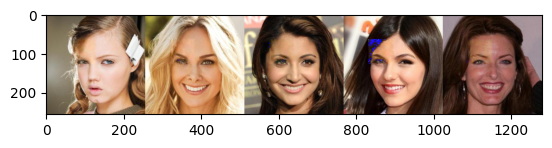

In [20]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

grid = make_grid(
    traj[-1, -5:].view([-1, 3, 256, 256]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

In [21]:
torch.save(model.state_dict(), "model_best.pth")